# Present Wrapping Problem

In [224]:
%load_ext autoreload
%load_ext iminizinc
%matplotlib inline
%autoreload 2

import string
import random
from time import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from z3 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


## Functions

In [225]:
def rand_str(size=10, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [90]:
def read_input(path):
    '''
    Read the given input instance, which should have the following format:
    
    W H
    N
    P1X P1Y
    ...
    PNX PNY

    Here, PIJ means present I, coordinate J, while W and H are the paper's dimensions
    '''
    file = open(path,"r").readlines()
    w_paper , h_paper = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n = int(file[1].rstrip("\n"))
    presents = []
    for i in range(2, n + 2):
        presents.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return w_paper, h_paper, n, presents

In [110]:
def show_solutions(w_paper, h_paper, n, presents, solutions):
    '''
    Show each and every solution as 2D plots
    '''
    assert(isinstance(solutions, list))

    colors = np.random.rand(n, 3)
    for solution in solutions:
        show_solution(w_paper, h_paper, n, presents, solution, colors)

def show_solution(w_paper, h_paper, n, presents, solution, colors=None):
    '''
    Show the given solution as a 2D plot. 
    The solution should be a list of bottom left corners, 
    contained in the given w_paper and h_paper margins
    '''
    assert(isinstance(w_paper, int))
    assert(isinstance(h_paper, int))
    assert(isinstance(presents, list))
    assert(isinstance(n, int) and n == len(presents))
    assert(isinstance(solution, list))
    assert(len(presents) == len(solution))

    if colors is None:
        colors = np.random.rand(n, 3)
    fig, ax = plt.subplots()
    for i in range(n):
        ax.add_patch(patches.Rectangle(
            solution[i],
            presents[i][0],
            presents[i][1],
            facecolor=colors[i]
        ))
    ax.set_xlim(0, w_paper)
    ax.set_ylim(0, h_paper)
    print(f"Solution: {solution}")
    plt.show()

In [118]:
def show_running_times(instances, times):
    '''
    Show instance size versus running time plot
    '''
    plt.xlabel("Instance")
    plt.ylabel("Total running time")
    plt.plot(instances, times, marker='o', linestyle='dashed', linewidth=2, markersize=12)
    plt.show()

In [86]:
def order_presents(presents, method='height', reverse=False):
    '''
    Order presents, increasing or decreasing, 
    by the given method (area, height, width)
    '''
    to_sort = (
        [e[0] * e[1] for e in presents] if method == 'area'
        else [e[1] for e in presents] if method == 'height'
        else [e[0] for e in presents] if method == 'width'
        else None
    )
    sorted_indices = sorted(range(len(to_sort)), key=lambda k: to_sort[k], reverse=reverse)
    presents = [presents[i] for i in sorted_indices]
    return presents, sorted_indices

In [92]:
def output(w_paper, h_paper, n, presents, solution, model):
    '''
    Write the given solution to an output file, in a specific output folder,
    with the following format:
    
    W H
    N
    P1X P1Y  C1X C1Y
    ...
    PNX PNY  CNX CNY

    Here, PIJ means present I, coordinate J; 
    CIJ means coordinate J of the bottom left corner of present I; 
    while W and H are the paper's dimensions
    '''
    out_file = open(f"out/{model}/{w_paper}x{h_paper}-out.txt", "w+")
    print(f"{w_paper} {h_paper}", file=out_file)
    print(f"{n}", file=out_file)
    for present, position in zip(presents, solution):
        present_x, present_y = present
        position_x, position_y = position
        print(f"{present_x} {present_y}{2 * ' '}{position_x} {position_y}", file=out_file)
    out_file.close()

## CP

### Input

In [211]:
instance = 8
min_instance, max_instance = 8, 40

Paper dimensions: 8x8
Presents dimensions: [[5, 5], [3, 5], [5, 3], [3, 3]]
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=28
mzn-stat: flatIntVars=44
mzn-stat: flatBoolConstraints=6
mzn-stat: flatIntConstraints=79
mzn-stat: evaluatedReifiedConstraints=4
mzn-stat: evaluatedHalfReifiedConstraints=24
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.0956184
mzn-stat-end
mzn-stat: initTime=0.001186
mzn-stat: solveTime=0.000179
mzn-stat: solutions=1
mzn-stat: variables=80
mzn-stat: propagators=81
mzn-stat: propagations=237
mzn-stat: nodes=4
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=3
mzn-stat-end
Solution: [[0, 0], [5, 0], [0, 5], [5, 5]]


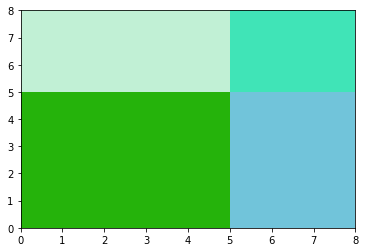

Instance size / Running time plot:


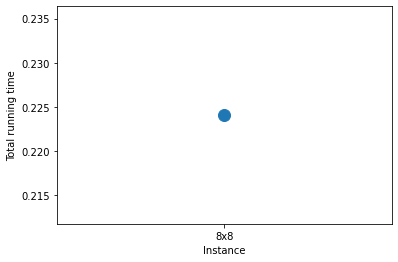

In [213]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    current_instance = f"{i}x{i}"
    instances.append(current_instance)
    path = f"instances/{current_instance}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    unordered_presents = list(presents)
    presents, sorted_indices = order_presents(presents, method='area', reverse=True)
    bl_corners = []
    print(f"Paper dimensions: {i}x{i}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    solutions = %minizinc -s pwp-v6
    end_time = time()
    times.append(end_time - start_time)
    if solutions:
        solution = solutions['bl_corners'] if 'bl_corners' in solutions else solutions[0]['bl_corners']
        show_solution(w_paper, h_paper, n, presents, solution)
        output(w_paper, h_paper, n, presents, solution, model='cp')
print("Instance size / Running time plot:")
show_running_times(instances, times)

### First model 

In [88]:
%%mzn_model pwp-v1
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of var 0..max(w_paper, h_paper) - 1: bl_corners;
array[1..n, 1..2] of int: presents;
constraint forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] <= w_paper);
constraint forall(i in 1..n) (bl_corners[i, 2] + presents[i, 2] <= h_paper);
constraint forall(i, j in 1..n where j > i) (
    max(bl_corners[i, 1], bl_corners[j, 1]) >= min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) \/
    max(bl_corners[i, 2], bl_corners[j, 2]) >= min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2])
);
solve satisfy;

### Second model

In [93]:
%%mzn_model pwp-v2
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

function var int: coord_to_value(var int: x, var int: y) = x + y * (max_dim + 1);
function var int: x_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) - max(bl_corners[i, 1], bl_corners[j, 1]));
function var int: y_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2]) - max(bl_corners[i, 2], bl_corners[j, 2]));
function var int: overlap_area(int: i, int: j) = x_overlap(i, j) * y_overlap(i, j);

array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n] of var 0..max_dim * max_dim: bl_corners_values;

predicate values_channeling(int: i) = 
    forall(i in 1..n) (bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]));
constraint forall(i in 1..n) (values_channeling(i));

constraint alldifferent(bl_corners_values);
constraint count_eq(bl_corners_values, 0, 1);
constraint forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] <= w_paper);
constraint forall(i in 1..n) (bl_corners[i, 2] + presents[i, 2] <= h_paper);
constraint forall(i, j in 1..n where j > i) (overlap_area(i, j) == 0);
solve satisfy;

### Third model

In [97]:
%%mzn_model pwp-v3
include "globals.mzn";
int: w_paper;
int: h_paper;
int: n;
int: max_dim = max(w_paper, h_paper);
array[1..n, 1..2] of 1..max_dim: presents;
array[1..n] of 1..max_dim: presents_xs = [presents[i, 1] | i in 1..n];
array[1..n] of 1..max_dim: presents_ys = [presents[i, 2] | i in 1..n];
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

function var int: coord_to_value(var int: x, var int: y) = x + y * (max_dim + 1);

array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n, 1..2] of var 1..max_dim: tr_corners;
array[1..n] of var 0..max_dim * max_dim: bl_corners_values;
array[1..n] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[1..n] of var 0..h_paper - min_present_dim: bl_corners_ys;

predicate values_channeling(int: i) = 
    forall(i in 1..n) (bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]));
constraint forall(i in 1..n) (values_channeling(i));

predicate bl_corners_channeling(int: i) = 
    forall(i in 1..n) (bl_corners[i, 1] == bl_corners_xs[i] /\ bl_corners[i, 2] == bl_corners_ys[i]);
constraint forall(i in 1..n) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    forall(i in 1..n) (bl_corners[i, 1] + presents[i, 1] == tr_corners[i, 1] /\ bl_corners[i, 2] + presents[i, 2] == tr_corners[i, 2]);
constraint forall(i in 1..n) (tr_corners_channeling(i));

constraint alldifferent(bl_corners_values);
constraint count_eq(bl_corners_values, 0, 1);
constraint diffn_k(bl_corners, presents);
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);
solve satisfy;

### Fourth model

In [127]:
%%mzn_model pwp-v4
include "globals.mzn";

%Input values
int: w_paper;
int: h_paper;
int: n;
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
array[ns, 1..2] of int: presents;
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..(w_paper * h_paper) - 1: bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };

function int: other_axis(int: axis) = if axis == 1 then 2 elseif axis == 2 then 1 else 0 endif;

% Constraints
predicate bl_corners_channeling(int: i) = bl_corners_xs[i] == bl_corners[i, 1] /\ bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Reduce presents domains
constraint forall(i in ns) (bl_corners_xs[i] <= w_paper - presents_xs[i] /\ bl_corners_ys[i] <= h_paper - presents_ys[i]);
constraint forall(i in ns) (tr_corners[i, 1] >= presents_xs[i] /\ tr_corners[i, 2] >= presents_ys[i]);

%Presents in the same column ordered by width
%constraint forall(i, j in ns where j > i) ( (bl_corners_xs[i] == bl_corners_xs[j] /\ presents_xs[i] <= presents_xs[j]) -> bl_corners_ys[i] > bl_corners_ys[j]);

%2 presents sum to h_paper or w_paper
%constraint forall(i, j in ns where j > i)(presents_xs[i] == presents_xs[j] /\ presents_ys[i] + presents_ys[j] == h_paper -> bl_corners_ys[j] = presents_ys[i] /\ bl_corners_ys[i] = 0);
%constraint forall(i, j in ns where j > i)(presents_ys[i] == presents_ys[j] /\ presents_xs[i] + presents_xs[j] == w_paper -> bl_corners_xs[j] = presents_xs[i] /\ bl_corners_xs[i] = 0);

%First present in the lower left quadrant
%constraint bl_corners_xs[1] <= w_paper / 2 /\ bl_corners_ys[1] <= h_paper / 2;

%Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) <= total_paper_area;
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) == total_presents_area;

%All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

%One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

%Presents cannot overlap
constraint diffn_k(bl_corners, presents);

constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);


%constraint bl_corners_xs[1] == 0 /\ bl_corners_ys[1] == 0;
%constraint bl_corners_xs[max_present_ind]<=(w_paper - presents_xs[max_present_ind])/2 /\ bl_corners_ys[max_present_ind]<=(h_paper - presents_ys[max_present_ind])/2;

%solve :: int_search(bl_corners_values, dom_w_deg, indomain_min) :: restart_luby(100) satisfy;
%solve minimize sum(bl_corners_values);
solve satisfy;

### Fifth model (with rotation)

In [207]:
%%mzn_model pwp-v5
include "globals.mzn";


%Input values
int: w_paper;
int: h_paper;
int: n;
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);

set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
set of int: presents_ys_values = distinct_values(presents_ys);
    
array[ns, 1..2] of int: presents;
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[ns] of int: x_intervals_sizes = [ceil(presents_xs[i] * 0.35) | i in ns]; 
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_values];
array[1..card(presents_xs_values)] of int: group_columns = [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];


% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns, 1..4] of var 0..coord_to_value(w_paper, h_paper): corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;
%array[ns, 1..2] of var 0..w_paper: x_intervals;


% Functions
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);

function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };

function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};

function int: other_axis(int: axis) = if axis == 1 then 2 elseif axis == 2 then 1 else 0 endif;

function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);

predicate is_col_stacking_feasible() = forall(i in 1..card(presents_xs_values))(sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper);

% Constraints
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[indexes[h]] == sum([weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );

constraint trace("\nCol_Stacking: "++show(is_col_stacking_feasible())++"\n\n",is_col_stacking_feasible()) -> forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Channeling constraints
/*
predicate x_intervals_channeling(int: i) = 
    x_intervals[i, 2] == x_intervals[i, 1] + x_intervals_sizes[i] /\
    bl_corners_xs[i] >= x_intervals[i, 1] /\
    bl_corners_xs[i] <= x_intervals[i, 2];
constraint forall(i in ns) (x_intervals_channeling(i));
*/
predicate corners_values_channeling(int: i) = 
    corners_values[i,1] == bl_corners_values[i] /\ 
    corners_values[i,2] == coord_to_value(bl_corners_xs[i] + presents_xs[i], bl_corners_ys[i]) /\
    corners_values[i,3] == coord_to_value(tr_corners[i,1], tr_corners[i,2]) /\
    corners_values[i,4] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i] + presents_ys[i]);
constraint forall(i in ns) (corners_values_channeling(i));

predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

/*
% Reduce corners domains based on x intervals
constraint forall(i, j in ns where j != i) (
    not(
        bl_corners_xs[j] < x_intervals[i, 2] + presents_xs[i] - x_intervals_sizes[i] /\ 
        bl_corners_xs[j] > x_intervals[i, 2] /\
        bl_corners_ys[j] >= bl_corners_ys[i] /\
        bl_corners_ys[j] < bl_corners_ys[i] + presents_ys[i]     
    )
);
*/

% Reduce presents domains
%constraint forall(i in ns) (bl_corners_xs[i] <= w_paper - presents_xs[i] /\ bl_corners_ys[i] <= h_paper - presents_ys[i]);
%constraint forall(i in ns) (tr_corners[i,1] >= presents_xs[i] /\ tr_corners[i,2] >= presents_ys[i]);

% Corners anchor points
predicate anchor_points() =
    let {
        array[1..n * 4] of var int: lin_corners_values = array1d(1..n * 4, corners_values)
    } in
    nvalue(lin_corners_values) <= 2 * n + 2 /\ 
    count_eq(lin_corners_values, coord_to_value(0, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(0, w_paper), 1) /\
    count_eq(lin_corners_values, coord_to_value(h_paper, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(w_paper, h_paper), 1);
%constraint anchor_points();

%Presents in the same column ordered by width
%constraint forall(i, j in ns where j > i) ( (bl_corners_xs[i] == bl_corners_xs[j] /\ presents_xs[i] <= presents_xs[j]) -> bl_corners_ys[i] > bl_corners_ys[j]);

%2 presents sum to h_paper or w_paper
%constraint forall(i,j in ns where j > i)(presents_xs[i] == presents_xs[j] /\ presents_ys[i] + presents_ys[j]==h_paper -> bl_corners_ys[j]=presents_ys[i] /\ bl_corners_ys[i] = 0);
%constraint forall(i,j in ns where j > i)(presents_ys[i] == presents_ys[j] /\ presents_xs[i] + presents_xs[j]==w_paper -> bl_corners_xs[j]=presents_xs[i] /\ bl_corners_xs[i] = 0);

%First present in the lower left quadrant
%constraint bl_corners_xs[1] <= w_paper / 2 /\ bl_corners_ys[1] <= h_paper / 2;

%Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) <= total_paper_area;
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) == total_presents_area;

%All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

%One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

%Presents cannot overlap
%constraint diffn_k(bl_corners, presents);

constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

%constraint bl_corners_xs[1] == 0 /\ bl_corners_ys[1] == 0;
%constraint bl_corners_xs[max_present_ind]<=(w_paper - presents_xs[max_present_ind])/2 /\ bl_corners_ys[max_present_ind]<=(h_paper - presents_ys[max_present_ind])/2;

%solve :: int_search(bl_corners_values, dom_w_deg, indomain_min) :: restart_luby(100) satisfy;
%solve minimize sum(bl_corners_values);
solve satisfy;
/*
solve :: seq_search([
             int_search(x_intervals, smallest, indomain_min),
             int_search(bl_corners_xs, smallest, indomain_min),
             int_search(bl_corners_ys, smallest, indomain_min)
         ]) satisfy;
*/

### Sixth model

In [168]:
%%mzn_model pwp-v6
include "globals.mzn";


%Input values
int: w_paper;
int: h_paper;
int: n;
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: max_dim = max(w_paper, h_paper);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);

set of int: ns = 1..n;

array[ns, 1..2] of int: presents;
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[int] of int: order = sort_by(ns, [-presents_xs[i] * presents_ys[i] | i in ns]);

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);

predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);
constraint diffn_k(bl_corners, presents);

constraint forall(i in ns)(
    member([0] ++ [bl_corners_xs[j] + presents_xs[j] | j in ns where j != i], bl_corners_xs[i]) /\
    member([0] ++ [bl_corners_ys[j] + presents_ys[j] | j in ns where j != i], bl_corners_ys[i])
);

constraint forall(i in ns)(
    bl_corners_xs[i] + presents_xs[i] <= w_paper /\
    bl_corners_ys[i] + presents_ys[i] <= h_paper
);

% Symmetry breaking
constraint let {int: o1 = order[1], int: o2 = order[2]} in lex_less([bl_corners_ys[o1], bl_corners_xs[o1]], [bl_corners_ys[o2], bl_corners_xs[o2]]);

constraint forall(i in ns)(
    let {array[int] of int: I = [j | j in ns where presents_xs[j] = presents_xs[i] /\ presents_ys[j] = presents_ys[i]]} in 
    if length(I) > 1 /\ min(I) = i then
        forall(j in index_set(I) where j > 1)(lex_less([bl_corners_ys[I[j - 1]], bl_corners_xs[I[j - 1]]], [bl_corners_ys[I[j]], bl_corners_xs[I[j]]]))
    else true 
    endif
);

%All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

%One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

%Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) <= total_paper_area;
constraint sum(i in ns) ((tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])) == total_presents_area;

constraint forall(i in ns) (bl_corners_xs[i] <= w_paper - presents_xs[i] /\ bl_corners_ys[i] <= h_paper - presents_ys[i]);
constraint forall(i in ns) (tr_corners[i,1] >= presents_xs[i] /\ tr_corners[i,2] >= presents_ys[i]);

solve :: seq_search([
    int_search([bl_corners_ys[i] | i in order], input_order, indomain_min, complete),
    int_search([bl_corners_xs[i] | i in order], input_order, indomain_min, complete)
]) satisfy;

## SMT

### Functions

In [281]:
def member(x, l):
    '''
    Return a contraint computing membership testing
    '''
    return Or([x == l[i] for i in range(len(l))])

def z3_max_list(l):
    '''
    Return a constraint computing the maximum over a list of variables
    '''
    c = []
    max_value = Int(rand_str())
    c.append(member(max_value, l))
    for i in range(len(l)):
        c.append(max_value >= l[i])
    return max_value, c

def z3_max(x, y):
    '''
    Return a constraint computing the maximum of two variables
    '''
    return If(x > y, x, y)

def z3_min_list(l):
    '''
    Return a constraint computing the minimum over a list of variables
    '''
    c = []
    min_value = Int(rand_str())
    c.append(member(min_value, l))
    for i in range(len(l)):
        c.append(min_value <= l[i])
    return min_value, c

def z3_min(x, y):
    '''
    Return a constraint computing the minimum of two variables
    '''
    return If(x < y, x, y)

def z3_bool2int(v):
    '''
    Convert a boolean variable to an integer one
    '''
    return IntSort().cast(v)

def z3_diffn(x, y, dx, dy):
    '''
    Return a list of constraints computing non-overlapping checks
    '''
    c = []
    n = len(x)
    for i in range(n):
        for j in range(i + 1, n):
            c.append(
                And(Or([
                    x[i] + dx[i] <= x[j],
                    y[i] + dy[i] <= y[j],
                    x[j] + dx[j] <= x[i],
                    y[j] + dy[j] <= y[i]
                ]))
            )
    return c

def z3_cumulative(s, d, r, b, ls, us):
    '''
    Return a list of constraints computing cumulative checks.
    Here, resources `r`, durations `d` and bound `b` must be fixed
    '''
    c = []
    early = ls
    late = us + max(d)
    tasks = [i for i in range(len(s)) if r[i] > 0 and d[i] > 0]
    if late - early < 5000:
        for i in tasks:
            c1 = []
            for j in tasks:
                if j != i:
                    c1.append(z3_bool2int(And(s[j] <= s[i], s[i] < s[j] + d[j])) * r[j])
            c.append(b >= r[i] + Sum(c1))
    else:
        for t in range(early, late + 1):
            for i in tasks:
                c.append(
                    Sum([(If(s[i] <= t, 1, 0) * If(t < s[i] + d[i], 1, 0)) * r[i] for i in tasks]) <= b
                )
    return c

### Input

In [288]:
instance = 24
min_instance, max_instance = 8, 40

In [289]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    current_instance = f"{i}x{i}"
    instances.append(current_instance)
    path = f"instances/{current_instance}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    print(f"Paper dimensions: {i}x{i}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    bl_corners, model = smt_v1(w_paper, h_paper, n, presents)
    model.check()
    assignment = model.model()
    solution = [[assignment[bl_corners[i][0]].as_long(), assignment[bl_corners[i][1]].as_long()] for i in range(n)]
    end_time = time()
    total_time = end_time - start_time
    times.append(total_time)
    print(model.statistics())
    print(f"Total running time: {round(total_time, 3)} seconds")
    if solution:
        show_solution(w_paper, h_paper, n, presents, solution)
        output(w_paper, h_paper, n, presents, solution, model='smt')
print("Instance size / Running time plot:")
show_running_times(instances, times)

Paper dimensions: 24x24
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]


Z3Exception: model is not available

### First model

In [280]:
def smt_v1(w_paper, h_paper, n, presents):
    presents_xs = [presents[i][0] for i in range(n)]
    presents_ys = [presents[i][1] for i in range(n)]
    bl_corners = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n) ]
    bl_corners_xs = [bl_corners[i][0] for i in range(n)]
    bl_corners_ys = [bl_corners[i][1] for i in range(n)]
    domain = [
        And(
            0 <= bl_corners[i][0], bl_corners[i][0] <= w_paper - presents[i][0], 
            0 <= bl_corners[i][1], bl_corners[i][1] <= h_paper - presents[i][1]
        ) for i in range(n)
    ]
    no_overlap = z3_diffn(bl_corners_xs, bl_corners_ys, presents_xs, presents_ys)
    x_bound = z3_cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper, 0, w_paper - 1);
    y_bound = z3_cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper, 0, h_paper - 1);

    model = Solver()
    model.add(domain + intersection + no_overlap + x_bound + y_bound)
    return bl_corners, model